In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.animation import FuncAnimation
from scipy.stats import uniform
from observision_models import NormalObservation, StudentTObservation
from IPython.display import HTML
from matplotlib.animation import ImageMagickWriter

from ball_throwing_simulator import BallThrowingSimulator

# Simulate ball throwing and generate Observations

(4, 3)
(121, 4, 3) (120, 2, 3)


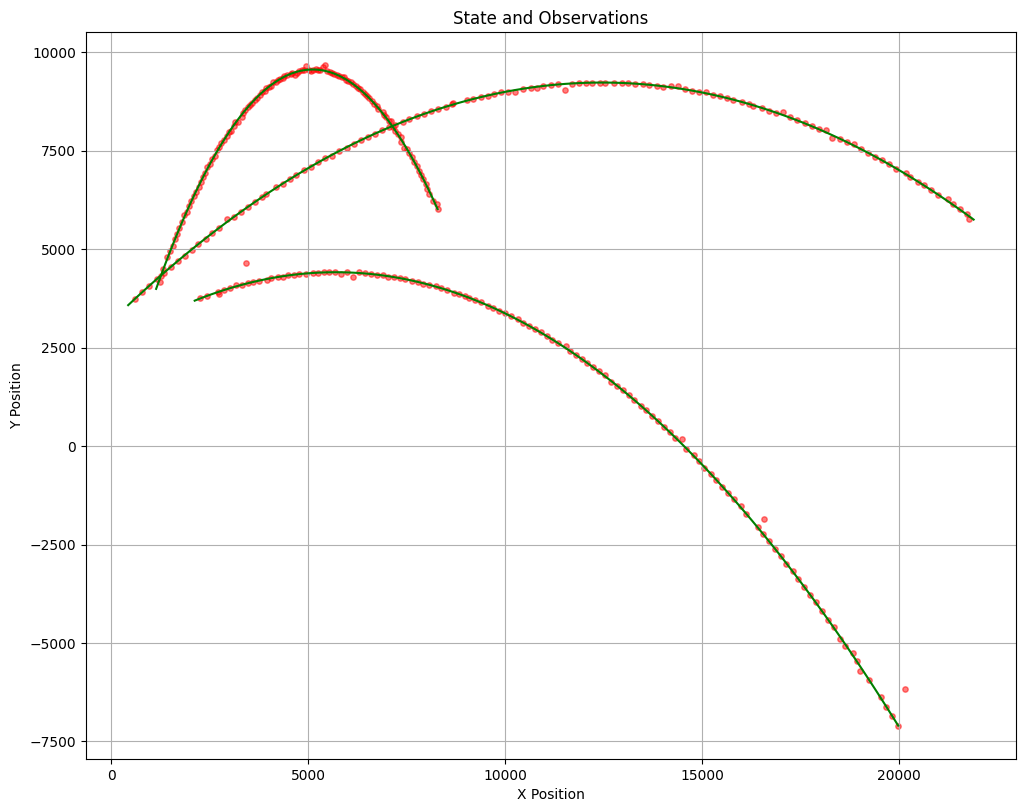

In [ ]:
ball_num = 3
delta_t = 0.5

# create observ model for simulating and particle filter
# observ_model = NormalObservation(ball_num, 2000)
observ_model = StudentTObservation(ball_num=ball_num, v=1, scale=2)

# init_state = np.array([[0], [50], [300], [300]])  # Initial state: [x, y, vx, vy]
simulator = BallThrowingSimulator(delta_t=delta_t, init_state=None, ball_num=ball_num, observ_model=observ_model)
# Simulate the motion and observations
states, observations = simulator.simulate(time=60)
print(states.shape, observations.shape)
# Show the simulated states and observations
fig, ax = plt.subplots(figsize=(12, 12))
plot_observations(ax, states, observations)
plt.show()

# Initilaize
## State
$$[X, Y, V_x, V_y]^T$$

## Uniform Random Particle Sets
$$X, Y \in [0, 3000]$$
$$V_x, V_y \in [0, 200]$$

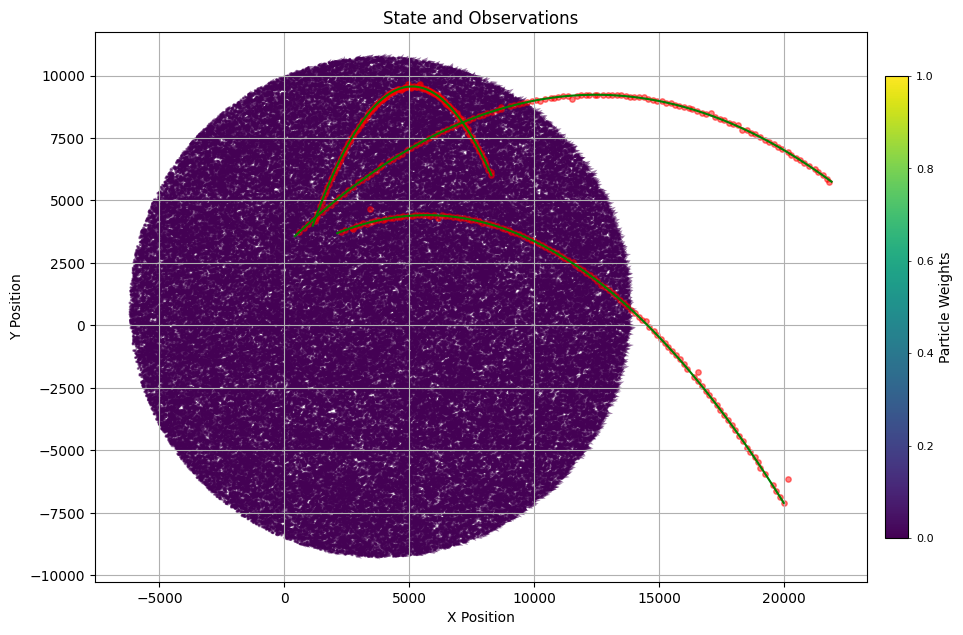

In [3]:
from partickle_filter import ParticleFilter
pf = ParticleFilter(delta_t, 10000*ball_num, ball_num, observ_model)

init_particles, init_weights = pf.init_particles, pf.init_weights

# show initial particles
fig, ax = plt.subplots(figsize=(12, 12))
# ax.set_xlim(0, 3000)
# ax.set_ylim(0, 3000)
ax.set_title('Initial Particles')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
plot_particles(ax, init_particles, init_weights)
plot_observations(ax, states, observations)
plt.show()

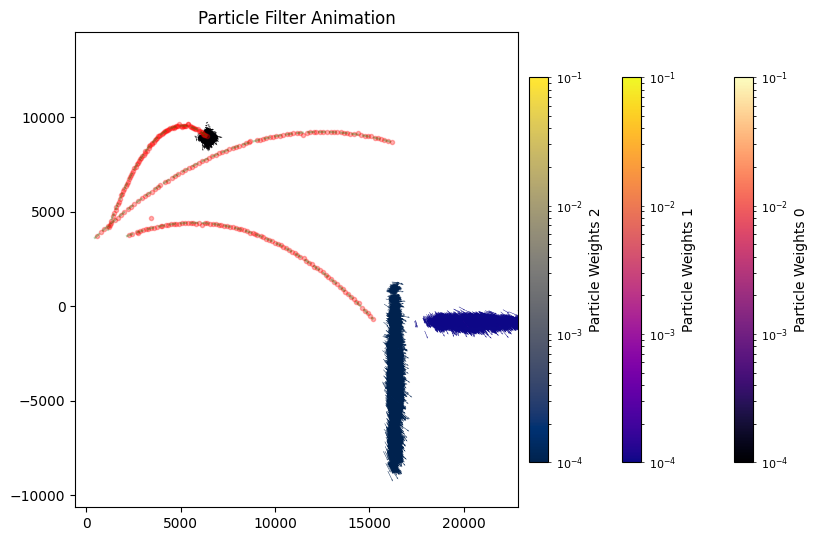

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from IPython.display import clear_output, display
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
import logging

# 假设已有变量: states, observations, pf（含 pf.snaps、pf.update）

# 输出目录
os.makedirs("outputs", exist_ok=True)

# 初始化画布
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Particle Filter Animation")
print(states.shape, observations.shape)
all_x = np.concatenate((states[:, 0], observations[:, 0]))
all_y = np.concatenate((states[:, 1], observations[:, 1]))
x_min, x_max = np.min(all_x) - 1000, np.max(all_x) + 1000
y_min, y_max = 1.5*np.min(all_y), 1.5 * np.max(all_y)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_aspect('equal')


# 初始化粒子状态
particles, weights = pf.init_particles, pf.init_weights

# use log norm to visulize weights
norm = LogNorm(vmin=1e-4, vmax=1e-1)  # 你可以根据权重范围调整

colormap_names = list(plt.colormaps.keys())[0:2*ball_num:2]
sms = [ScalarMappable(norm=norm, cmap=plt.get_cmap(name)) for name in colormap_names]

quivers = []
observ_slots = []
state_slots = []

for i in range(ball_num):
    # 初始化绘图对象
    particles_quiver = ax.quiver(particles[:,0, i], particles[:, 1, i], 
                                particles[:, 2, i], particles[:, 3, i], 
                                color = sms[i].to_rgba(weights),
                                angles='xy', scale_units='xy', scale=1, width=0.001)
    quivers.append(particles_quiver)

    observations_plot, = ax.plot([], [], 'r.', label='Observations', alpha=0.3)
    observ_slots.append(observations_plot)
    true_state_plot, = ax.plot(states[0, 0, i], states[0, 1, i], 'g--', label='True State', alpha=0.3)
    state_slots.append(true_state_plot)

    # draw clor bar
    cbar = plt.colorbar(sms[i], ax=ax, shrink=0.5, pad=0.02)
    cbar.set_label(f'Particle Weights {i}')
    # make colorbar smaller
    cbar.ax.tick_params(labelsize=8, length=2, width=0.5)

# plt.legend()

plt.savefig(f"outputs/frame_000.png", dpi=150)
display(fig)
# 主循环：逐帧绘图并保存为 PNG
for frame in range(1, states.shape[0]):
    particles, weights = pf.update(particles, weights, observations[frame-1])

    for i in range(ball_num):
        particles_quiver, observations_plot, true_state_plot  = quivers[i], observ_slots[i], state_slots[i]

        particles_quiver.set_offsets(particles[:, :2, i])
        particles_quiver.set_UVC(particles[:, 2, i], particles[:, 3, i])
        particles_quiver.set_color(sms[i].to_rgba(weights))

        observations_plot.set_data(observations[:frame, 0, i], observations[:frame, 1, i])
        true_state_plot.set_data(states[:frame+1, 0, i], states[:frame+1, 1, i])

    clear_output(wait=True)
    display(fig)
    # 保存帧
    plt.savefig(f"outputs/frame_{frame:03d}.png", dpi=150)

# plt.close(fig)  # 完成后关闭图形
plt.ioff()
plt.close(fig)

# save to gif
gif_frames = [Image.open(f"outputs/frame_{frame:03d}.png") for frame in range(states.shape[0])]
gif_path = "outputs/particle_filter_animation.gif"
gif_frames[0].save(gif_path, save_all=True, append_images=gif_frames[1:], duration=300, loop=0)
